## CS287r Final Project
## Language Model Notebook

## Install Libraries 

In [1]:
# !pip install biopython
# !pip install -q torch torchtext opt_einsum
# !pip install -qU git+https://github.com/harvardnlp/namedtensor


     |████████████████████████████████| 2.2MB 5.0MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 


In [2]:
## Upload cds file..

#!wget -m ftp://ftp.ensemblgenomes.org/pub/release-43/bacteria//fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/cdna/
#!mv ftp.ensemblgenomes.org/pub/release-43/bacteria/fasta/bacteria_0_collection/escherichia_coli_str_k_12_substr_mg1655/cdna/Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cdna.all.fa.gz ./ 
#!unzip "Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cdna.all.fa.gz"

from google.colab import files
uploaded = files.upload()


Saving ecoli_CDS.fasta to ecoli_CDS.fasta


In [0]:
mv Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cdna.all.fa ecoli_CDS.fasta

mv: cannot stat 'Escherichia_coli_str_k_12_substr_mg1655.ASM584v2.cdna.all.fa': No such file or directory


In [2]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqUtils import CodonUsage
from Bio.SeqUtils import IUPACData
import torch
import torchtext
from namedtensor import ntorch
from namedtensor.text import NamedField
from sklearn.ensemble import RandomForestClassifier
from nltk.util import ngrams
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
# from google.colab import files
import pandas as pd
import math
import random
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from collections import defaultdict

## Import data

In [3]:
# Our input $x$
# Prepend with a start token
tokenize = lambda x : ["<START>"] + re.findall('.{%d}' % 3, x)
TEXT = NamedField(names=("seqlen", ), sequential=True, 
                  lower=True, tokenize=tokenize)
AA_LABEL = NamedField(names=("seqlen", ), 
                  lower=True)



In [4]:
# Note: Fairly round about way of getting this loaded into pytorch..
# Wrangling data into format pytorch language prefers.. 
sequences = [str(rec.seq) for rec in SeqIO.parse("sequences/ecoli_CDS.fasta", "fasta") if len(rec.seq) % 3 == 0]
df = pd.DataFrame(sequences, columns=["sequence"])
df.to_csv("cds.csv", index=False, header=False)

In [5]:
sequences_ = [rec.seq for rec in SeqIO.parse("ecoli_CDS.fasta", "fasta") if len(rec.seq) % 3 == 0]
tokenize(str(sequences_[0][:21*3]))

['<START>',
 'GTG',
 'TCA',
 'CTT',
 'TCG',
 'CTT',
 'TGG',
 'CAG',
 'CAG',
 'TGT',
 'CTT',
 'GCC',
 'CGA',
 'TTG',
 'CAG',
 'GAT',
 'GAG',
 'TTA',
 'CCA',
 'GCC',
 'ACA',
 'GAA']

In [6]:
#generate all DNA triplets
bases = "tcag"
codons = [a + b + c for a in bases for b in bases for c in bases]
aa = [str(Seq(j).translate()) for j in codons]
codon_to_aa = dict(zip(codons, aa))


#create one hot of AA encoding
AA_LABEL.build_vocab(aa)

In [7]:
my_data = torchtext.data.TabularDataset("cds.csv", format="CSV", 
                                        fields=[("sequence", TEXT)])

In [8]:
train, test = my_data.split(split_ratio=0.7)

In [9]:
TEXT.build_vocab(train)

In [10]:
from torchtext.data import Iterator, BucketIterator
 
#we don't split genes
train_iter_bucket, test_iter_bucket = torchtext.data.BucketIterator.splits(
    (train, test), batch_sizes=(10,10), sort_within_batch=False, sort_key=lambda x : len(x.sequence),
    device=torch.device(device, ))

In [11]:
# Make a look up table, such that you can index with the vocab item (e.g. a codon)
# and get the one hot corresponding to its amino acid
one_hot_vec = torch.eye(len(AA_LABEL.vocab))
zero_vec =  torch.zeros(len(AA_LABEL.vocab), 1)
direct_look_up = [one_hot_vec[AA_LABEL.vocab.stoi[codon_to_aa[TEXT.vocab.itos[i]]]].unsqueeze(1) 
                  if TEXT.vocab.itos[i] in codon_to_aa else zero_vec
                  for i in range(len(TEXT.vocab.stoi))]

# Codon x one hot 
index_table = torch.cat(direct_look_up, dim=1).t()

In [0]:
####

# TEXT.vocab.itos[x]: retrieves codon given numbering in the order of 


TEXT.vocab.itos[num]: retrieves codon given numbering in the encoding position

TEXT.vocab.stoi["gaa"]: retrieves encoding given codon

codon_to_aa: dictionary. key: codon, val: AA

AA_LABEL.vocab.stoi[AA]: retrieves AA encoding given AA
AA_LABEL.vocab.itos[num]: retrieves AA given AA encoding

In [12]:
codon_to_aa_index = torch.argmax(index_table, 1)

In [13]:
codon_embed = TEXT.vocab.stoi["aat"]
print(codon_embed)

# One hot of amino acid embedding
index_table[codon_embed]

25


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0.])

In [14]:
batch = next(iter(train_iter_bucket))

In [15]:
embed = ntorch.nn.Embedding.from_pretrained(index_table).spec("seqlen", "onehot").to(device)
embed(batch.sequence).shape

OrderedDict([('batch', 10), ('seqlen', 749), ('onehot', 23)])

In [16]:
# Build masking table
# Here, if it's a synonymous option, give it 0 value, if not, give -1e9
# Add this with the output vector (i.e. output += mask_tbl[trg]) before softmax
mask_tbl = torch.tensor(np.array([[0 if (codon in codon_to_aa and codon_2 in codon_to_aa and codon_to_aa[codon] == codon_to_aa[codon_2]) else -1e9 
           for codon_2 in TEXT.vocab.itos] 
          for index, codon in enumerate(TEXT.vocab.itos)])).to(device)


In [17]:
print("CODON", TEXT.vocab.itos[4], TEXT.vocab.itos[42])

mask_tbl[4]

CODON aaa aag


tensor([-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,  0.0000e+00,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09,  0.0000e+00, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,
        -1.0000e+09, -1.0000e+09], dtype=torch.floa

In [18]:
max_seq_len = 0
for batch in train_iter_bucket:
  if batch.sequence.shape["seqlen"] > max_seq_len: 
    max_seq_len = batch.sequence.shape["seqlen"] 

for batch in test_iter_bucket:
  if batch.sequence.shape["seqlen"] > max_seq_len: 
    max_seq_len = batch.sequence.shape["seqlen"] 

print(max_seq_len)

2369


## Import Data (Character Level Model)

In [19]:
tokenize_char = lambda x : ["<START>"] + list(x)
TEXT_CHAR = NamedField(names=("seqlen", ), sequential=True, 
                  lower=True, tokenize=tokenize_char)

In [0]:
my_data_char = torchtext.data.TabularDataset("cds.csv", format="CSV", 
                                        fields=[("sequence", TEXT_CHAR)])

In [0]:
train_char, test_char = my_data_char.split(split_ratio=0.7)

In [0]:
TEXT_CHAR.build_vocab(train_char)

In [0]:
TEXT_CHAR.vocab.stoi

defaultdict(<function torchtext.vocab._default_unk_index>,
            {'<pad>': 1,
             '<start>': 6,
             '<unk>': 0,
             'a': 5,
             'c': 3,
             'g': 2,
             't': 4})

In [0]:
from torchtext.data import Iterator, BucketIterator
 
#we don't split genes
train_iter_char_bucket, test_iter_char_bucket = torchtext.data.BucketIterator.splits(
    (train_char, test_char), batch_sizes=(10,10), sort_within_batch=False, sort_key=lambda x : len(x.sequence),
    device=torch.device(device, ))

## Make frequency table for reference

In [20]:
def count_codons_iter(train_iter):
  ''' Calculate the counts of each codon given subset of a CDS
  
  Args:
    Train iter
    
  Returns:
    dict{str, int}: dictionary with codons as key and corresponding number of occurences
  
  '''
  codons_dict = CodonUsage.CodonsDict.copy()
  for i, batch in enumerate(train_iter):

    # Select for all non zero tensors
    # Use this to find all indices that aren't padding
    seq_len = batch.sequence.shape["seqlen"]
    batch_size = batch.sequence.shape["batch"]
    seq = batch.sequence.detach().cpu().numpy()
    for batch_item in range(batch_size): 
      for seq_item in range(0, seq_len):
        word = seq[seq_item, batch_item]
        if TEXT.vocab.itos[word] in codon_to_aa: 
          codons_dict[TEXT.vocab.itos[word].upper()] += 1
        elif TEXT.vocab.itos[word] == "<pad>": 
          # Break loop if we are at padding...
          seq_item = seq_len + 1
          
   
  return codons_dict

def count_codons_fasta(fasta_file):
  ''' Calculate the counts of each codon given a set of CDS
  
  Args:
    Fasta file 
    
  Returns:
    dict{str, int}: dictionary with codons as key and corresponding number of occurences
  
  '''
  
  codons_dict = CodonUsage.CodonsDict.copy()
  
  for record in SeqIO.parse(fasta_file, "fasta"):
    seq = record.seq
    if len(seq) % 3 != 0:
      continue
      
    #count the codons for this sequence
    for codon_start in range(0, len(seq), 3):
      codons_dict[str(seq[codon_start:codon_start+3])] += 1
   
  return codons_dict

def calculate_codon_frequency(codon_counts):
  ''' Calculate the counts of each codon given a set of CDS
  
  Args:
    codon usage table
    
  Returns:
    dict{str, float}: dictionary with codons as key and corresponding 
    frequency of codon for AA
  
  '''
  codon_freqs = CodonUsage.CodonsDict.copy()
  
  for _, synonymous_codons in CodonUsage.SynonymousCodons.items():
    total_AA_count = sum([codon_counts[codon] for codon in synonymous_codons])
    
    if total_AA_count == 0:
      continue
      
    for codon in synonymous_codons:
      codon_freqs[codon] = codon_counts[codon] / total_AA_count
  
  return codon_freqs

eColi_codon_counts = count_codons_fasta("ecoli_CDS.fasta")
# eColi_codon_counts = count_codons_iter(train_iter_bucket)
eColi_codon_table = calculate_codon_frequency(eColi_codon_counts)

In [21]:
def make_unigram_conversion(train_iter): 
  ''' Help make table... '''
  eColi_codon_counts = count_codons_iter(train_iter)
  eColi_codon_table = calculate_codon_frequency(eColi_codon_counts)
  unigram_freq_tbl = torch.tensor(np.array([[eColi_codon_table[codon_2.upper()] if (codon in codon_to_aa and codon_2 in codon_to_aa and codon_to_aa[codon] == codon_to_aa[codon_2]) else 0 
             for codon_2 in TEXT.vocab.itos] 
            for index, codon in enumerate(TEXT.vocab.itos)])).to(device)
  
  pad_index = TEXT.vocab.stoi["<pad>"]
  unigram_freq_tbl[pad_index,pad_index] = 1
  return unigram_freq_tbl 


unigram_freq_tbl = make_unigram_conversion(train_iter_bucket)

#### N gram frequency helpers

In [22]:
def make_n_gram(train_iter, n, amino_acid_conversion):
  '''
  n : the number to each side...
      e.g. 0 gram corresponds to freq, 1 gram corresponds to 3, etc.
  amino_acid_conversion: tensor used to convert seq to AA one hots
  '''
  with torch.no_grad():
    n_grams = []
    targets = []
    ident_mat = np.eye(len(TEXT.vocab.stoi))
    ident_mat_aa = np.eye(len(AA_LABEL.vocab))
    for i, batch in enumerate(train_iter):
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      batch_size = batch.sequence.shape["batch"]

      # Pad amino acids and seq with <pad> token 
      pad_token = TEXT.vocab.stoi["<pad>"]
      additional_padding = ntorch.ones(batch_size, n, 
                                      names=("batch", "seqlen")).long()
      additional_padding *= pad_token
      
      seq = ntorch.cat([additional_padding, batch.sequence, additional_padding],
                      dim="seqlen")
      
      # Now one hots.. 
      amino_acids = amino_acid_conversion[seq.values].detach().cpu().numpy()
      # Note: we should assert that start and pad are treated the same
      # This is because at test time, presumably we narrow the start for the AA.. 
      if i == 0:
        assert((amino_acids[0,n] == amino_acids[0,0]).all())
      
      seq = seq.detach().cpu().numpy()
      # Pad with padding token
      for batch_item in range(batch_size): 
        # start at n, end at seq_len - n
        for seq_item in range(n, seq_len - n):
          # Middle token is a discrete number representing the codon (0 to 66)
          middle_token = seq[batch_item, seq_item]
          # N gram is a 2d numpy array containing an amino acid embedding in each row
          n_gram = amino_acids[batch_item,seq_item - n : seq_item + n + 1]
          
          # If we want all one hots:
          # n_grams.append(ident_mat_aa[n_gram])
          # targets.append(ident_mat[middle_token])

          # If we want all indices:
          n_grams.append(n_gram)
          targets.append(middle_token)
          
  return n_grams, targets




def build_dictionary(n_grams, targets): 
  ''' Takes n grams and targets and makes them into '''
  default_obj = lambda : torch.tensor(np.zeros(len(TEXT.vocab.stoi)))
  default_dict = defaultdict(default_obj)
  
  for n_gram, target in zip(n_grams, targets): 
    default_dict[str(n_gram)][target] += 1
    
  for key in default_dict: 
    default_dict[key] /= (default_dict[key]).sum()
    
  return default_dict

In [23]:
# n_grams are indices in amino acid space, targets are indices in codon space
# n_grams, targets = make_n_gram(train_iter_bucket, 0, codon_to_aa_index)

# Language modeling

## Models

### Codon Level Models 

#### AA_COMPRESS
A model to compress a codon sequence into its amino acid representation
Can be easily used by passing in an embedding that turns each amino acid into a onehot OR each amino acid into a frequency table representation for its codon (unigram model)

In [24]:
class AA_COMPRESS(ntorch.nn.Module):
  '''
  Compress info for codon sequence at the amino acid level
  '''
  
  def __init__(self, params): 
    super(AA_COMPRESS, self).__init__()
    self.codon_to_aa = params["CODON_TO_AA"]
    self.aa_embed = (ntorch.nn.Embedding.from_pretrained(self.codon_to_aa)
                     .spec("seqlen", "hiddenlen"))
    
    # don't learn these.. 
    self.aa_embed.weight.requires_grad_(False)  
    
  def forward(self, seq): 
    return self.aa_embed(seq)    

#### AA_NGRAM
A model class that will take a string of codons and turn them into amino acids, then turn those amino acids into n gram based frequencies for what codon should be predicted in each position


In [25]:
class AA_NGRAM(ntorch.nn.Module):
  '''
  Compress info for codon sequence at the amino acid level
  TODO: Ignore pading predicts in forward pass to save time
  '''
  
  def __init__(self, params): 
    super(AA_NGRAM, self).__init__()
    self.codon_to_aa = params["CODON_TO_AA"]
    self.dict_list = params["N_GRAM_DICTS"]
    # How many indcies each dict takes
    self.n_list = params["N_LIST"]
    # probability to apply to each n gram used
    self.weight_list = params["WEIGHT_LIST"]
    self.longest_n = max(self.n_list)
    self.out_vocab = params["OUT_VOCAB"]
    
  def forward(self, seq): 
    
    seq_len = seq.shape["seqlen"]
    batch_size = seq.shape["batch"]
      
    pad_token = TEXT.vocab.stoi["<pad>"]
    additional_padding = ntorch.ones(batch_size, self.longest_n, 
                                    names=("batch", "seqlen")).long()
    additional_padding *= pad_token
    
    seq = ntorch.cat([additional_padding, seq, additional_padding],
                    dim="seqlen")
    
    
    amino_acids = self.codon_to_aa[seq.values]
    
    return_ar = ntorch.zeros(seq_len, batch_size, self.out_vocab,
                             names=("seqlen", "batch", "vocablen"))
    
    # convert to numpy to leave GPU 
    amino_acids = amino_acids.detach().cpu().numpy()
    for batch_item in range(batch_size): 
      # start at n, end at seq_len - n
      for seq_item in range(self.longest_n, seq_len - self.longest_n):        
        # Must iterate over all dictionaries
        for weight, n, ngram_dict in zip(self.weight_list, 
                                         self.n_list, self.dict_list):          
          # N gram is a 2d numpy array containing an amino acid embedding in each row
          n_gram = amino_acids[batch_item,seq_item - n : seq_item + n + 1]

          # note, we want to populate the return ar before padding!
          return_ar[{"seqlen" : seq_item - self.longest_n, 
                     "batch" : batch_item}] += weight * ngram_dict[str(n_gram)].float()

    return return_ar
  

 

#### AA_BILSTM
A model to compress a codon sequence into its amino acid representation and then run a bidirectional LSTM over this sequence

In [0]:
class AA_BILSTM(ntorch.nn.Module):
  '''
  Compress info for codon sequence at the amino acid level
  '''
  
  def __init__(self, params): 
    super(AA_BILSTM, self).__init__()
    self.codon_to_aa = params["CODON_TO_AA"]
    self.embedding_size = params["EMBED_DIM"]
    self.hiddenlen = params["HIDDEN_LEN"]
    self.num_layers = params["NUM_LAYERS"]
    self.lstm_dropout = params["LSTM_DROPOUT"]
    self.bidirectional = params["BIDIRECTIONAL"]
    self.num_directions = 1
    if self.bidirectional:
      self.num_directions = 2
    
    self.aa_embed = (ntorch.nn.Embedding.from_pretrained(self.codon_to_aa)
                     .spec("seqlen", "embedlen"))
    
    # don't learn these.. 
    self.aa_embed.weight.requires_grad_(False)  
    
    self.LSTM = (ntorch.nn.LSTM(self.embedding_size, self.hiddenlen,
                                num_layers=self.num_layers, 
                                bidirectional=self.bidirectional
                               )
                .spec("embedlen", "seqlen", name_out="hiddenlen")
                )
    
    
  def forward(self, seq): 
    '''
    Forward pass
    ''' 
    aa_rep = self.aa_embed(seq)    
    h_0 = ntorch.zeros(self.num_layers * self.num_directions, aa_rep.shape["batch"], self.hiddenlen, 
                        names=("layers", "batch", "hiddenlen")).to(device)
    c_0 = ntorch.zeros(self.num_layers * self.num_directions, aa_rep.shape["batch"], self.hiddenlen, 
                        names=("layers", "batch", "hiddenlen")).to(device)
    
    h_0 = h_0.transpose("batch", "layers", "hiddenlen")
    c_0 = c_0.transpose("batch", "layers", "hiddenlen")
    hidden_states, (h_n, c_n) = self.LSTM(aa_rep, (h_0, c_0))
    
    return hidden_states
    

    


#### Frequency Based Model
A unigram model that only uses a single amino acid to do prediction

In [0]:
class FreqModel(ntorch.nn.Module):
  ''' 
  Simple language model that uses the frequencies of the amino acids for modeling
  Magic happens in aa_info model
  '''
  def __init__(self):
    super(FreqModel, self).__init__()

  def forward(self, text, aa_info):
    ''' 
      Pass in context for the next amino acid
    '''

    return aa_info.rename("hiddenlen", "vocablen")

#### Codon Level Language Model 
A model that uses the previously predicted (or true) codons in addition to provided information about the amino acid for prediction

In [0]:
class NNLM(ntorch.nn.Module):
  ''' 
  Simple LSTM class.
  '''
  def __init__(self, params):
    super(NNLM, self).__init__()
    self.vocab_size = params["VOCAB_SIZE"]
    self.embedding_size = params["EMBED_DIM"]
    self.hiddenlen = params["HIDDEN_LEN"]
    self.num_layers = params["NUM_LAYERS"]
    self.linear_dropout = ntorch.nn.Dropout(p=params["LINEAR_DROPOUT"])
    self.lstm_dropout = params["LSTM_DROPOUT"]
    self.out_vocab = params["OUT_VOCAB"]
    self.aa_info_size = params["AA_COMPRESS_SIZE"]
    self.teacher_force_prob = params["TEACHER_FORCE"]
    if self.embedding_size is not None: 
      self.embedding = ntorch.nn.Embedding(num_embeddings=params["VOCAB_SIZE"], 
                                           embedding_dim = self.embedding_size).spec("seqlen", "embedlen")
    else: 
      self.embedding = (ntorch.nn.Embedding.
                        from_pretrained(torch.eye(len(TEXT.vocab.itos))
                                       )
                       ).spec("seqlen", "embedlen")
      
      self.embedding.weight.requires_grad_(False)
      self.embedding_size = len(TEXT.vocab.itos)
    
    self.LSTM = (ntorch.nn.LSTM(self.embedding_size, self.hiddenlen, num_layers=self.num_layers)
                .spec("embedlen", "seqlen", name_out="hiddenlen")
                )
    self.linear = (ntorch.nn.Linear(self.hiddenlen + self.aa_info_size, 
                                    self.out_vocab)
                   .spec("hiddenlen", "vocablen")
                  )
    
  def set_to_eval(self):
    self.dropout.eval()
  
  def set_teacher_force(self, new_prob):
    self.teacher_force_prob = new_prob
    
  def forward(self, text, aa_info):
    ''' 
      Pass in context for the next amino acid
    '''
    
    # Reset for each new batch...
    h_0 = ntorch.zeros(text.shape["batch"], self.num_layers, self.hiddenlen, 
                        names=("batch", "layers", "hiddenlen")).to(device)
    c_0 = ntorch.zeros(text.shape["batch"], self.num_layers, self.hiddenlen, 
                        names=("batch", "layers", "hiddenlen")).to(device)
 
    # If we should use all the sequence as input
    if self.teacher_force_prob == 1: 
      text_embedding = self.embedding(text)
      hidden_states, (h_n, c_n) = self.LSTM(text_embedding, (h_0, c_0))
      output = self.linear_dropout(hidden_states)
      output = ntorch.cat([output, aa_info], dim="hiddenlen")
      output = self.linear(output)
    
    # If we should use some combination of teacher forcing
    else: 
      # Use for teacher forcing...
      outputs = []
      model_input = text[{"seqlen" : slice(0, 1)}]
      for position in range(text.shape["seqlen"]): 
        text_embedding = self.embedding(model_input)
        hidden_states, (h_n, c_n) = self.LSTM(text_embedding, (h_0, c_0))

        output = self.linear_dropout(hidden_states)
        aa_info_subset = aa_info[{"seqlen" : slice(position, position+1)}]
        output = ntorch.cat([output, aa_info_subset], dim="hiddenlen")

        output = self.linear(output)
        outputs.append(output)

        # Define next input... 
        if random.random() < self.teacher_force_prob: 
          model_input = text[{"seqlen" : slice(position, position+1)}]
        else: 
          # TODO: Should we be masking this output?
          model_input = output.argmax("vocablen")
          
      output = ntorch.cat(outputs, dim="seqlen")
    return output
  

#### AA_ONLY 
A model that only uses a bidirectional LSTM over the amino acids in order to do prediction

In [0]:
class AA_ONLY(ntorch.nn.Module):
  ''' 
  Simple model to predict the output codons using only the input amino acid
  '''
  def __init__(self, params):
    super(AA_ONLY, self).__init__()
    self.out_vocab = params["OUT_VOCAB"]
    self.aa_info_size = params["AA_COMPRESS_SIZE"]
    self.linear = (ntorch.nn.Linear(self.aa_info_size, 
                                    self.out_vocab)
                   .spec("hiddenlen", "vocablen")
                  )
    
  def forward(self, text, aa_info):
    ''' 
      Pass in context for the next amino acid
    '''

    output = aa_info
    output = self.linear(output)
    return output
  

### Nucleotide Level Models

TODO

## Train, Acc, PPL

In [0]:
def train_model(train_iter, model, aa_compress, train_params, 
                optimizer, optimizer_aa=None):
  '''
  Train a given model 
  
  TODO: 
  - Mask all non synonymous codons in test only
    For now, we can do this at prediction time.. 
  - Precompute the text / target in the iterator function 
  
  NOTE: 
    Optimizer_aa is optional if we want to learn on the compressions.
  ''' 
  
  model.train()
  if "TEACHER_FORCE" in train_params:
    model.teacher_force_prob = train_params["TEACHER_FORCE"]

  if optimizer_aa is not None:
    # Does this accidentally turn on gradients? 
    aa_compress.train()
    
  loss_function = ntorch.nn.CrossEntropyLoss().spec("vocablen")
  model.to(device)
  aa_compress.to(device)
  loss_values = []
  for epoch in range(train_params["num_epochs"]):
    epoch_loss = 0
    for i, batch in enumerate(train_iter):
      model.zero_grad()
      if optimizer_aa: 
        aa_compress.zero_grad()

      
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
      target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
      
      stacked_target = target.stack(dims=("batch", "seqlen"), 
                                          name="seqlen")

      mask = (stacked_target != TEXT.vocab.stoi["<pad>"])
      prop_indices = (ntorch.nonzero(mask)
                      .get("inputdims", 0)
                     )
      # Forward
      predictions = model(text, aa_compress(target)) 
      
      # Stack the predictions into one long vector
      predictions = predictions.stack(dims=("batch", "seqlen"), name="seqlen")
            
      # Only find loss on sequences
      # TODO: Divide by batch size... 
      loss = loss_function(predictions.index_select("seqlen", prop_indices),
                           stacked_target.index_select("seqlen", prop_indices))
      
      epoch_loss += loss.item()
      
      loss.backward()
      # gradient clip
      torch.nn.utils.clip_grad_norm_(model.parameters(), train_params["grad_clip"])
      optimizer.step()
      
      if optimizer_aa: 
        torch.nn.utils.clip_grad_norm_(aa_compress.parameters(), train_params["grad_clip"])
        optimizer_aa.step()

      

    print("Epoch: {} -- Loss: {}".format(epoch, epoch_loss))        
    loss_values.append(epoch_loss)

  if train_params["plot_loss"]: 
    fig, ax = plt.subplots()
    ax.plot([t for t in range(len(loss_values))], loss_values)
    ax.set(xlabel='Epochs', ylabel='Loss', title='Loss during Optimization')
    plt.show()

  return model

#### Acc

In [0]:
def accuracy(data_iter, model, aa_compress, teacher_force=0):
  '''
  Produce accuracy (# correct / total)
  TODO: 
  - Mask all non synonymous codons in train
    For now, we can do this at prediction time.. 
  - Precompute the text / target in the iterator function 
  ''' 
  
  model.to(device)
  model.eval()
  model.teacher_force_prob = teacher_force
  aa_compress.to(device)
  aa_compress.eval()
  num_correct = 0 
  num_total = 0 
  with torch.no_grad():
    for i, batch in enumerate(data_iter):
      
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
      target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
      
      stacked_target = target.stack(dims=("batch", "seqlen"), 
                                          name="seqlen")
      mask = (stacked_target != TEXT.vocab.stoi["<pad>"])
      prop_indices = (ntorch.nonzero(mask)
                      .get("inputdims", 0)
                     ).rename("elements", "seqlen")
      # Forward
      predictions = model(text, aa_compress(target)) 
      # Mask all outputs that don't work
      mask_bad_codons = ntorch.tensor(mask_tbl[target.values], 
                         names=("seqlen", "batch", "vocablen")).float()
      predictions = (mask_bad_codons.double() + predictions.double())

     
      # Stack the predictions into one long vector
      predictions = predictions.stack(dims=("batch", "seqlen"), name="seqlen")

      predictions = predictions.argmax("vocablen").index_select("seqlen", 
                                                                prop_indices)
      stacked_target = stacked_target.index_select("seqlen", prop_indices)
            
      num_correct += (predictions == stacked_target).sum().item()   
      num_total += predictions.shape["seqlen"]
      
      # For quick results, toggle this
#       if i == 20: 
#         break
      
#   return num_correct / num_total 

  return (predictions, stacked_target, num_correct / num_total)

#### PPL 

In [0]:
def PPL(data_iter, model, aa_compress, teacher_force=0):
  '''
  Produce average ppl of prediction
  TODO: 
  - Mask all non synonymous codons in train
    For now, we can do this at prediction time.. 
  - Precompute the text / target in the iterator function 
  ''' 
  
  model.to(device)
  model.eval()
  model.teacher_force_prob = teacher_force
  aa_compress.to(device)
  aa_compress.eval()
  ppl = 0
  num_total = 0 
  loss_function = ntorch.nn.CrossEntropyLoss(reduction="none").spec("vocablen")
  with torch.no_grad():
    for i, batch in enumerate(data_iter):
      
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
      target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
      
      stacked_target = target.stack(dims=("batch", "seqlen"), 
                                          name="seqlen")
      mask = (stacked_target != TEXT.vocab.stoi["<pad>"])
      prop_indices = (ntorch.nonzero(mask)
                      .get("inputdims", 0)
                     ).rename("elements", "seqlen")
      # Forward
      predictions = model(text, aa_compress(target)) 
      # Mask all outputs that don't work
      mask_bad_codons = ntorch.tensor(mask_tbl[target.values], 
                         names=("seqlen", "batch", "vocablen")).float()
      predictions = (mask_bad_codons.double() + predictions.double())

     
      # Stack the predictions into one long vector
      predictions = predictions.stack(dims=("batch", "seqlen"), name="seqlen")
      loss = loss_function(predictions.index_select("seqlen", prop_indices),
                     stacked_target.index_select("seqlen", prop_indices))
      ppl += loss.exp().sum().item()
      num_total += loss.shape["seqlen"]      
      # For quick results, toggle this
#       if i == 20: 
#         break

  return ppl / num_total 

### Error analysis

In [0]:
def output_predictions_and_target(data_iter, model, aa_compress, teacher_force=0):
  '''
  Outputs matrix for prediction, target, and also the accuracy
  ''' 
  
  
  model.to(device)
  model.eval()
  model.teacher_force_prob = teacher_force
  aa_compress.to(device)
  aa_compress.eval()
  num_correct = 0 
  num_total = 0 
  
  prediction_list = []
  target_list = []
  
  with torch.no_grad():
    for i, batch in enumerate(data_iter):
      
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
      target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
      
      stacked_target = target.stack(dims=("batch", "seqlen"), 
                                          name="seqlen")
      mask = (stacked_target != TEXT.vocab.stoi["<pad>"])
      prop_indices = (ntorch.nonzero(mask)
                      .get("inputdims", 0)
                     ).rename("elements", "seqlen")
      # Forward
      predictions = model(text, aa_compress(target)) 
      # Mask all outputs that don't work
      mask_bad_codons = ntorch.tensor(mask_tbl[target.values], 
                         names=("seqlen", "batch", "vocablen")).float()
      predictions = (mask_bad_codons.double() + predictions.double())
      
     
      # Stack the predictions into one long vector
      predictions = predictions.stack(dims=("batch", "seqlen"), name="seqlen")

      predictions = predictions.argmax("vocablen").index_select("seqlen", 
                                                                prop_indices)
      
      prediction_list.append(predictions.cpu())
      
      stacked_target = stacked_target.index_select("seqlen", prop_indices)
      
      target_list.append(stacked_target.cpu())
            
      num_correct += (predictions == stacked_target).sum().item()   
      num_total += predictions.shape["seqlen"]

  return (prediction_list, target_list, num_correct / num_total)

In [0]:
def mismatched_indices(predict_list, target_list):
  '''
  Inputs prediction and true target, outputs mismatch list and mismatch positions
  
  mismatch list is a NUM_SEQUENCE x LEN_SEQUENCE list of lists, boolean values. 1 if prediction is correct, 0 if incorrect.
  (e.g. [0, 1, 1, 0, 0, ...])
  
  msimatch positions contains positions in which misclassification happened (e.g. [3, 4, 9, 13, 31])
  
  '''
  mismatch_list = []
  for i in range(len(predict_list)):
    mismatches = predict_list[i] != target_list[i]
    mismatch_list.append(np.array(mismatches.values))
  
  mismatch_positions = []
  for i in range(len(mismatch_list)):
    positions = [j for j, x in enumerate(mismatch_list[i]) if x == 1]
    mismatch_positions.append(positions)
    
  return (mismatch_list, mismatch_positions)

In [0]:
from collections import Counter
from itertools import zip_longest

def pool_mismatches(mismatch_list, mismatch_indices):
  '''
  Given mismatch list and mismatch positions, outputs error rate over sequence length
  
  METHOD: counts error in every position over all the test sequences. Misclassification at each position is counted,
  and normalized over how many sequences have a position there. (e.g. all 132 sequences have a nt in position 1, 
  but only a few would have it at position 9432.)
  
  
  '''
  collapsed_array = []
  for item in mismatch_indices:
    collapsed_array.extend(item)
    
  
  counts = Counter(collapsed_array)
  
  #normalize the counts
  seq_lengths = []
  for item in mismatch_list:
    seq_lengths.append(len(item))
      
  normalizing_list = np.array([0] * max(seq_lengths))

  for length in seq_lengths:
    normalizing_list = [sum(n) for n in zip_longest(normalizing_list, [1]*length, fillvalue=0)]
    
  for i in range(max(seq_lengths)):
    counts[i] = counts[i] / normalizing_list[i]
    
  normalized_counts = [0]*max(seq_lengths)
  
  for key in counts:
    try:
      normalized_counts[key] = counts[key]
    except:
      print (key)
    
  return normalized_counts
  

In [0]:
out = mismatched_indices(test_unigram_predicts, test_target_vals)
mismatch_over_sequence = pool_mismatches(out[0], out[1])

NameError: ignored

In [0]:
mismatch_over_sequence = pool_mismatches(out[0], out[1])

NameError: ignored

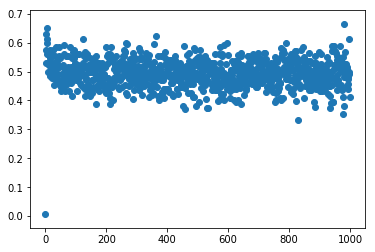

In [0]:
plt.scatter(range(len(mismatch_over_sequence))[:1000], mismatch_over_sequence[:1000])
plt.show()

In [0]:
range(132)

range(0, 132)

In [0]:
print ("HELLO")

HELLO


####  Preds

In [0]:
def get_prediction(batch, model, aa_compress): 
  ''' Predict outputs from sequence'''
  model.to(device)
  model.eval()
  with torch.no_grad():
    seq_len = batch.sequence.shape["seqlen"]
    text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
    target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
    # Forward
    predictions = model(text, aa_compress(target)) 
    mask_bad_codons = ntorch.tensor(mask_tbl[target.values], 
                       names=("seqlen", "batch", "vocablen")).float()
    predictions = (mask_bad_codons + predictions)
    predictions = predictions.argmax("vocablen")
  return predictions



## Unigram Model

In [0]:
unigram_freq_tbl = make_unigram_conversion(train_iter_bucket)

In [0]:


aa_compress_params = {
    "CODON_TO_AA" : unigram_freq_tbl
}


model = FreqModel()
aa_compress = AA_COMPRESS(aa_compress_params)
model.to(device), aa_compress.to(device)

(FreqModel(), AA_COMPRESS(
   (aa_embed): Embedding(67, 67)
 ))

In [0]:
test_unigram_predicts, test_target_vals, unigram_test_ac = output_predictions_and_target(test_iter_bucket, model, aa_compress)
# train_unigram_predicts, train_target_vals, unigram_train_ac = prediction_mismatches(test_iter_bucket, model, aa_compress)

# unigram_test_ac = accuracy(test_iter_bucket, model, aa_compress)

# print("Train accuracy: ", unigram_train_ac)
print("Test accuracy: ", unigram_test_ac)

Test accuracy:  0.5195127808520912


In [0]:
test_unigram_predicts[32]

NamedTensor(
	tensor([10, 19, 16,  ...,  4, 18, 62], device='cuda:0'),
	('seqlen',))

In [0]:
out = mismatched_indices(test_unigram_predicts, test_target_vals)
mismatch_over_sequence = pool_mismatches(out[0], out[1])

In [0]:
out = mismatched_indices(test_unigram_predicts, test_target_vals)
mismatch_over_sequence = pool_mismatches(out[0], out[1])
plt.scatter(range(len(mismatch_over_sequence))[:300], mismatch_over_sequence[:300])
plt.show()

In [0]:
test_ppl, train_ppl = (PPL(test_iter_bucket, model, aa_compress), 
                     PPL(train_iter_bucket, model, aa_compress))
print("Train PPL: ", train_ppl)
print("Test PPL: ", test_ppl)

Train PPL:  3.379582556636873
Test PPL:  3.395484078717863


In [0]:
test_unigram_predicts

NamedTensor(
	tensor([10, 28,  8,  ..., 19,  2, 63]),
	('seqlen',))

## N-gram model

In [0]:
# n_grams are indices in amino acid space, targets are indices in codon space
n_grams, targets = make_n_gram(train_iter_bucket, 0, codon_to_aa_index)
zero_dict = build_dictionary(n_grams, targets)

n_grams, targets = make_n_gram(train_iter_bucket, 1, codon_to_aa_index)
one_dict = build_dictionary(n_grams, targets)

n_grams, targets = make_n_gram(train_iter_bucket, 2, codon_to_aa_index)
two_dict = build_dictionary(n_grams, targets)

In [0]:
aa_params = {
    # convert each index to the aa index
    "CODON_TO_AA" : codon_to_aa_index,
    "N_GRAM_DICTS" : [zero_dict, one_dict],
    "N_LIST" : [0, 1],
    "WEIGHT_LIST" : [0.5, 0.5],
    "OUT_VOCAB" : len(TEXT.vocab.stoi)   
}




model = FreqModel()
aa_compress = AA_NGRAM(aa_params)
model.to(device), aa_compress.to(device)

(FreqModel(), AA_NGRAM())

In [0]:
# train ac should be higher.. something probably wrong.
test_ac, train_ac = (accuracy(test_iter_bucket, model, aa_compress),
                     accuracy(train_iter_bucket, model, aa_compress))
print("Train accuracy: ", train_ac)
print("Test accuracy: ", test_ac)

Train accuracy:  0.5508248362762165
Test accuracy:  0.48140406958873794


In [0]:
aa_params = {
    # convert each index to the aa index
    "CODON_TO_AA" : codon_to_aa_index,
    "N_GRAM_DICTS" : [two_dict],# [zero_dict, one_dict],
    "N_LIST" : [2],
    "WEIGHT_LIST" : [1],
    "OUT_VOCAB" : len(TEXT.vocab.stoi)   
}




model = FreqModel()
aa_compress = AA_NGRAM(aa_params)
model.to(device), aa_compress.to(device)

(FreqModel(), AA_NGRAM())

In [0]:
# train ac should be higher.. something probably wrong.
test_ac, train_ac = (accuracy(test_iter_bucket, model, aa_compress),
                     accuracy(train_iter_bucket, model, aa_compress))
print("Train accuracy: ", train_ac)
print("Test accuracy: ", test_ac)

## Language Model 

In [0]:
model_params = {
    "VOCAB_SIZE" : len(TEXT.vocab),
    "EMBED_DIM" : None, #50,
    "OUT_VOCAB": len(TEXT.vocab),
    "HIDDEN_LEN" : 200,
    "NUM_LAYERS" : 3,
    "LINEAR_DROPOUT" : 0.2,
    "LSTM_DROPOUT" : 0.2,    
    "AA_COMPRESS_SIZE" : index_table.shape[1],
    "TEACHER_FORCE" : 1
}

aa_compress_params = {
    "CODON_TO_AA" : index_table
}


train_params = {
    "num_epochs":30, 
    "lr":1e-3,  
    "weight_decay":1e-6,
    "device":device, 
    "grad_clip": 10, 
    "plot_loss" : True,
    "TEACHER_FORCE" : 1
}


model = NNLM(model_params)
aa_compress = AA_COMPRESS(aa_compress_params)
model.to(device), aa_compress.to(device)


(NNLM(
   (linear_dropout): Dropout(p=0.2)
   (embedding): Embedding(67, 67)
   (LSTM): LSTM(67, 200, num_layers=3, batch_first=True)
   (linear): Linear(in_features=223, out_features=67, bias=True)
 ), AA_COMPRESS(
   (aa_embed): Embedding(67, 23)
 ))

Epoch: 0 -- Loss: 1131.959959745407
Epoch: 1 -- Loss: 956.8145925998688
Epoch: 2 -- Loss: 804.2731750011444
Epoch: 3 -- Loss: 680.7200589179993
Epoch: 4 -- Loss: 581.9270281791687
Epoch: 5 -- Loss: 507.74945878982544
Epoch: 6 -- Loss: 454.8769830465317
Epoch: 7 -- Loss: 417.3328025341034
Epoch: 8 -- Loss: 389.7979357242584
Epoch: 9 -- Loss: 370.1917984485626
Epoch: 10 -- Loss: 355.9717655181885
Epoch: 11 -- Loss: 344.83047610521317
Epoch: 12 -- Loss: 336.1347362399101
Epoch: 13 -- Loss: 329.4694827198982
Epoch: 14 -- Loss: 323.8495211005211
Epoch: 15 -- Loss: 319.3141167163849
Epoch: 16 -- Loss: 315.29802906513214
Epoch: 17 -- Loss: 311.65382105112076
Epoch: 18 -- Loss: 307.7892631292343
Epoch: 19 -- Loss: 304.555812060833
Epoch: 20 -- Loss: 301.6094952225685
Epoch: 21 -- Loss: 297.9011378288269
Epoch: 22 -- Loss: 294.08951783180237
Epoch: 23 -- Loss: 290.21923410892487
Epoch: 24 -- Loss: 287.0164201259613
Epoch: 25 -- Loss: 283.3129064440727
Epoch: 26 -- Loss: 279.5372940301895
Epoch:

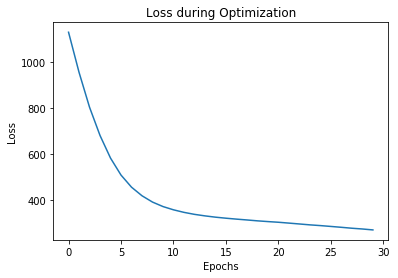

NNLM(
  (linear_dropout): Dropout(p=0.2)
  (embedding): Embedding(67, 67)
  (LSTM): LSTM(67, 200, num_layers=3, batch_first=True)
  (linear): Linear(in_features=223, out_features=67, bias=True)
)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_params["lr"], weight_decay=train_params["weight_decay"])
train_model(train_iter_bucket, model, aa_compress, train_params, optimizer)

In [0]:
test_ac, train_ac = (accuracy(test_iter_bucket, model, aa_compress, teacher_force=0), 
                     accuracy(train_iter_bucket, model, aa_compress, teacher_force=0))
print("Train accuracy: ", train_ac)
print("Test accuracy: ", test_ac)

Train accuracy:  (NamedTensor(
	tensor([10,  3, 36,  ...,  3, 57, 63], device='cuda:0'),
	('seqlen',)), NamedTensor(
	tensor([10,  3, 43,  ..., 24, 54, 65], device='cuda:0'),
	('seqlen',)), 0.4573393145671263)
Test accuracy:  (NamedTensor(
	tensor([10,  7, 16,  ..., 18, 15, 63], device='cuda:0'),
	('seqlen',)), NamedTensor(
	tensor([10,  7, 44,  ..., 62, 15, 63], device='cuda:0'),
	('seqlen',)), 0.45734250204643406)


In [0]:
test_ppl, train_ppl = (PPL(test_iter_bucket, model, aa_compress, teacher_force=0), 
                     PPL(train_iter_bucket, model, aa_compress, teacher_force=0))
print("Train PPL: ", train_ppl)
print("Test PPL: ", test_ppl)

In [0]:
test_ac = (accuracy(test_iter_bucket, model, aa_compress, teacher_force=0)


SyntaxError: ignored

## BiLSTM AA Level Only

Use only the Amino acids, not the true or predicted codons

In [0]:

aa_compress_params = {
    "CODON_TO_AA" : index_table,
    "EMBED_DIM" : index_table.shape[1],
    "HIDDEN_LEN" : 50, 
    "NUM_LAYERS" : 3, 
    "LSTM_DROPOUT" : 0.1,
    "BIDIRECTIONAL" : True
    
}


model_params = {
    "OUT_VOCAB": len(TEXT.vocab),
    "AA_COMPRESS_SIZE" : (aa_compress_params["HIDDEN_LEN"] * 
                          (2 if aa_compress_params["BIDIRECTIONAL"] else 1))
    
}


train_params = {
    "num_epochs":20, 
    "lr":1e-3,  
    "weight_decay":1e-6,
    "device":device, 
    "grad_clip": 10, 
    "plot_loss" : True
}




model = AA_ONLY(model_params)
aa_compress = AA_BILSTM(aa_compress_params)
model.to(device), aa_compress.to(device)


In [0]:

optimizer = torch.optim.Adam(model.parameters(), lr=train_params["lr"],
                             weight_decay=train_params["weight_decay"])
optimizer_aa = torch.optim.Adam(aa_compress.parameters(), 
                                lr=train_params["lr"], 
                                weight_decay=train_params["weight_decay"])


train_model(train_iter_bucket, model, aa_compress, train_params,
            optimizer, optimizer_aa)

In [0]:
test_ac, train_ac = (accuracy(test_iter_bucket, model, aa_compress), 
                     accuracy(train_iter_bucket, model, aa_compress))
print("Train accuracy: ", train_ac)
print("Test accuracy: ", test_ac)

In [0]:
test_ppl, train_ppl = (PPL(test_iter_bucket, model, aa_compress), 
                       PPL(train_iter_bucket, model, aa_compress))
print("Train PPL: ", train_ppl)
print("Test PPL: ", test_ppl)

In [0]:
print (AA_BILSTM)

## RNN + BiLSTM 

In [0]:

aa_compress_params = {
    "CODON_TO_AA" : index_table,
    "EMBED_DIM" : index_table.shape[1],
    "HIDDEN_LEN" : 50, 
    "NUM_LAYERS" : 3, 
    "LSTM_DROPOUT" : 0.1,
    "BIDIRECTIONAL" : True
    
}


model_params = {
    "VOCAB_SIZE" : len(TEXT.vocab),
    "EMBED_DIM" : None, #50,
    "OUT_VOCAB": len(TEXT.vocab),
    "HIDDEN_LEN" : 100,
    "NUM_LAYERS" : 2,
    "LINEAR_DROPOUT" : 0.2,
    "LSTM_DROPOUT" : 0.2,    
    "AA_COMPRESS_SIZE" : (aa_compress_params["HIDDEN_LEN"] * 
                          (2 if aa_compress_params["BIDIRECTIONAL"] else 1)),
    "TEACHER_FORCE" : 1
    
}


train_params = {
    "num_epochs":30, 
    "lr":1e-3,  
    "weight_decay":1e-6,
    "device":device, 
    "grad_clip": 20, 
    "plot_loss" : True,
    "teacher_force" : 1
}




model = NNLM(model_params)
aa_compress = AA_BILSTM(aa_compress_params)
model.to(device), aa_compress.to(device)


(NNLM(
   (linear_dropout): Dropout(p=0.2)
   (embedding): Embedding(67, 67)
   (LSTM): LSTM(67, 100, num_layers=2, batch_first=True)
   (linear): Linear(in_features=200, out_features=67, bias=True)
 ), AA_BILSTM(
   (aa_embed): Embedding(67, 23)
   (LSTM): LSTM(23, 50, num_layers=3, batch_first=True, bidirectional=True)
 ))

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_params["lr"],
                             weight_decay=train_params["weight_decay"])
optimizer_aa = torch.optim.Adam(aa_compress.parameters(), 
                                lr=train_params["lr"], 
                                weight_decay=train_params["weight_decay"])

train_model(train_iter_bucket, model, aa_compress, train_params,
            optimizer, optimizer_aa)

Epoch: 0 -- Loss: 726.3023167848587
Epoch: 1 -- Loss: 308.15690463781357
Epoch: 2 -- Loss: 299.08718305826187
Epoch: 3 -- Loss: 296.0259350538254
Epoch: 4 -- Loss: 293.42268323898315
Epoch: 5 -- Loss: 292.2179016470909
Epoch: 6 -- Loss: 291.55719166994095
Epoch: 7 -- Loss: 290.16761857271194
Epoch: 8 -- Loss: 289.27620780467987
Epoch: 9 -- Loss: 288.74894523620605
Epoch: 10 -- Loss: 287.961663544178
Epoch: 11 -- Loss: 287.9280743598938


KeyboardInterrupt: ignored

In [0]:
test_ac, train_ac = (accuracy(test_iter_bucket, model, aa_compress, teacher_force=1), 
                     accuracy(train_iter_bucket, model, aa_compress, teacher_force=1))
print("Train accuracy: ", train_ac)
print("Test accuracy: ", test_ac)

Train accuracy:  (NamedTensor(
	tensor([10, 10, 11, 16, 51, 17, 18, 36, 36, 17, 17, 19, 48, 23, 17, 36, 50, 16,
        36, 48, 37, 23,  4, 51, 12, 23, 63,  8, 27, 19,  9, 18, 53, 52, 22, 15,
        51,  9, 63,  4, 63, 63, 58, 57, 51, 11, 23,  4, 27, 38, 51,  4, 19, 10,
        58, 42, 23,  4, 19, 23, 65, 10,  4, 11, 44, 17,  3,  9, 34,  4,  5,  5,
        17, 19, 18, 11,  2,  7, 47, 18,  8, 23,  6, 28,  3, 33,  5,  6, 12, 57,
        12,  3, 10, 17, 12, 18, 15, 15,  3, 28,  8, 23, 37, 28, 43,  8, 23, 19,
        18, 26, 16, 18, 17,  7,  9, 31,  2,  3, 24,  8,  6,  7,  7, 53,  6,  5,
         9, 16,  4, 18,  7, 15, 28,  2,  8,  5,  7,  3,  9, 32,  6,  5,  9, 18,
        47,  7, 14, 19,  2, 15,  5, 42,  4, 10, 10,  6, 18, 12,  7,  3,  2,  5,
        12,  6, 43, 14,  7,  8,  2, 11,  5,  2, 18, 19, 12, 19, 43, 32, 10, 18,
         8, 14, 28, 27,  8, 32,  9,  5,  5,  3,  4,  8, 27, 13,  8,  7, 54, 32,
        15, 19, 47,  7,  5, 11, 10, 16, 16, 32,  8,  5,  4, 25, 54, 20,  7,  8,
        

In [0]:
test_ppl, train_ppl = (PPL(test_iter_bucket, model, aa_compress, teacher_force=1), 
                     PPL(train_iter_bucket, model, aa_compress, teacher_force=1))
print("Train PPL: ", train_ppl)
print("Test PPL: ", test_ppl)

Train PPL:  3.545165146657026
Test PPL:  3.8990431628178577


In [0]:
test_lstm_predicts, test_target_vals, lstm_test_ac = output_predictions_and_target(test_iter_bucket, model, aa_compress, teacher_force = 0)
# train_unigram_predicts, train_target_vals, unigram_train_ac = prediction_mismatches(test_iter_bucket, model, aa_compress)

# unigram_test_ac = accuracy(test_iter_bucket, model, aa_compress)

# print("Train accuracy: ", unigram_train_ac)
# print("Test accuracy: ", test_lstm_ac)

In [0]:
lstm_test_ac

0.552258961673331

In [0]:
def convert_output_to_DNA(predicts):
  seqs = []
  
  for pred in predicts:
    seq = []
    for j in range(len(pred)):
      seq.append(TEXT.vocab.itos[np.array(pred.values)[j]])
    
    dna_seq = "".join(seq).upper()
    seqs.append(dna_seq)
    
  return seqs

In [0]:
output_seqs = convert_output_to_DNA(test_lstm_predicts)

In [0]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqUtils import CodonUsage
from Bio.SeqUtils import IUPACData

import random
import csv

In [0]:
def count_codons(DNA_seq):
  ''' Calculate the counts of each codon given a CDS
  
  Args:
    dna sequence in indexable form
    
  Returns:
    dict{str, int}: dictionary with codons as key and corresponding number of occurences
  
  '''
  
  codons_dict = CodonUsage.CodonsDict.copy()
  for codon_start in range(0, len(DNA_seq), 3):
    codons_dict[str(DNA_seq[codon_start:codon_start+3])] += 1
   
  return codons_dict


def count_codons_fasta(fasta_file):
  ''' Calculate the counts of each codon given a set of CDS
  
  Args:
    Fasta file 
    
  Returns:
    dict{str, int}: dictionary with codons as key and corresponding number of occurences
  
  '''
  
  codons_dict = CodonUsage.CodonsDict.copy()
  
  for record in SeqIO.parse(fasta_file, "fasta"):
    seq = record.seq
    if len(seq) % 3 != 0:
      continue
      
    #count the codons for this sequence
    for codon_start in range(0, len(seq), 3):
      codons_dict[str(seq[codon_start:codon_start+3])] += 1
   
  return codons_dict

def count_codons_list(seqs):
  ''' Calculate the counts of each codon given list of seqs
  
  Args:
    Fasta file 
    
  Returns:
    dict{str, int}: dictionary with codons as key and corresponding number of occurences
  
  '''
  
  codons_dict = CodonUsage.CodonsDict.copy()
  
  for seq in seqs:
    if len(seq) % 3 != 0:
      continue
      
    #count the codons for this sequence
    for codon_start in range(0, len(seq), 3):
      codons_dict[str(seq[codon_start:codon_start+3])] += 1
   
  return codons_dict

def calculate_codon_frequency(codon_counts):
  ''' Calculate the counts of each codon given a set of CDS
  
  Args:
    codon usage table
    
  Returns:
    dict{str, float}: dictionary with codons as key and corresponding 
    frequency of codon for AA
  
  '''
  codon_freqs = CodonUsage.CodonsDict.copy()
  
  for _, synonymous_codons in CodonUsage.SynonymousCodons.items():
    total_AA_count = sum([codon_counts[codon] for codon in synonymous_codons])
    
    if total_AA_count == 0:
      continue
      
    for codon in synonymous_codons:
      codon_freqs[codon] = codon_counts[codon] / total_AA_count
  
  return codon_freqs

In [0]:
lstm_codon_table = count_codons_list(output_seqs)

In [0]:
sum([lstm_codon_table[key] for key in lstm_codon_table])

387259

In [0]:
calculate_codon_frequency(lstm_codon_table)

{'AAA': 0.9963053487182402,
 'AAC': 0.6207480776749642,
 'AAG': 0.003694651281759791,
 'AAT': 0.37925192232503585,
 'ACA': 0.0,
 'ACC': 0.764034253092293,
 'ACG': 0.23372978116079923,
 'ACT': 0.002235965746907707,
 'AGA': 0.00022966331358228838,
 'AGC': 0.7082299690995343,
 'AGG': 4.593266271645767e-05,
 'AGT': 0.004439221830526178,
 'ATA': 8.149295085975064e-05,
 'ATC': 0.2722679488224269,
 'ATG': 1.0,
 'ATT': 0.7276505582267134,
 'CAA': 0.27123995407577495,
 'CAC': 0.2496993549797748,
 'CAG': 0.728760045924225,
 'CAT': 0.7503006450202252,
 'CCA': 0.028163358953768498,
 'CCC': 0.01238958357232993,
 'CCG': 0.8962372375817368,
 'CCT': 0.06320981989216473,
 'CGA': 0.0,
 'CGC': 0.595241376142575,
 'CGG': 0.02388498461255799,
 'CGT': 0.3805980432685683,
 'CTA': 0.0,
 'CTC': 0.06438978901969926,
 'CTG': 0.9013404825737266,
 'CTT': 0.01997901853362863,
 'GAA': 0.8579420315390714,
 'GAC': 0.14609145643628402,
 'GAG': 0.14205796846092855,
 'GAT': 0.8539085435637159,
 'GCA': 0.07225940089228808

In [45]:
target_seqs = convert_output_to_DNA(test_target_vals)

NameError: ignored

In [0]:
target_codon_table = count_codons_list(target_seqs)

In [0]:
calculate_codon_frequency(target_codon_table)

{'AAA': 0.7706474165861422,
 'AAC': 0.5516095399452626,
 'AAG': 0.22935258341385778,
 'AAT': 0.44839046005473737,
 'ACA': 0.1317316841103711,
 'ACC': 0.4326831588962892,
 'ACG': 0.26622264509990484,
 'ACT': 0.16936251189343482,
 'AGA': 0.04000734922603463,
 'AGC': 0.2738390564477521,
 'AGG': 0.020210371595241375,
 'AGT': 0.15162989076032554,
 'ATA': 0.0764403879064461,
 'ATC': 0.4155325564338685,
 'ATG': 1.0,
 'ATT': 0.5080270556596854,
 'CAA': 0.344833524684271,
 'CAC': 0.4261506504864983,
 'CAG': 0.655166475315729,
 'CAT': 0.5738493495135017,
 'CCA': 0.19215326373752437,
 'CCC': 0.12395319490650453,
 'CCG': 0.5248938855110703,
 'CCT': 0.15899965584490078,
 'CGA': 0.06651049561343071,
 'CGC': 0.3980524551008222,
 'CGG': 0.09696385099444214,
 'CGT': 0.3782554774700289,
 'CTA': 0.03527217624431752,
 'CTC': 0.10404476046159226,
 'CTG': 0.49609511598088357,
 'CTT': 0.10257605781559623,
 'GAA': 0.6876046163333627,
 'GAC': 0.3674677812608847,
 'GAG': 0.3123953836666373,
 'GAT': 0.6325322187

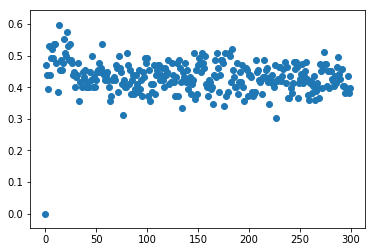

In [0]:
out = mismatched_indices(test_lstm_predicts, test_target_vals)
mismatch_over_sequence = pool_mismatches(out[0], out[1])
plt.scatter(range(len(mismatch_over_sequence))[:300], mismatch_over_sequence[:300])
plt.show()

## Model inspection

In [0]:
# Example
batch = next(iter(train_iter_bucket))

In [0]:
seqlen = batch.sequence.shape['seqlen']
src = batch.sequence.narrow('seqlen',0,seqlen-1)
trg = batch.sequence.narrow('seqlen', 1,seqlen-1)
aa_compress(trg)
model(src, aa_compress(trg)).shape

In [0]:
output = model(src, aa_compress(trg))
mask_vec = ntorch.tensor(mask_tbl[trg.values], 
                         names=("seqlen", "batch", "vocablen")).float()
output = (mask_vec + output)

In [0]:
preds = get_prediction(batch, model, aa_compress)

In [0]:
preds.shape

In [0]:
def translate_to_seq(x): 
  ''' Takes in single tensor of name seqlen'''
  my_str = "".join([TEXT.vocab.itos[i] for i in x.values])
  my_str = my_str.split("<pad>")[0]
  my_str = my_str.split("<unk>")[0]

  if "<start>" in my_str: 
    my_str = my_str.split("<start>")[1]
    
    
  
  return my_str.upper()

In [0]:
src_str = translate_to_seq(batch.sequence.get("batch", 0))
res_str = translate_to_seq(preds.get("batch", 0))


In [0]:
Seq(src_str).translate(), Seq(res_str).translate()

In [0]:
src_str_tok = np.array(tokenize(src_str))
res_str_tok = np.array(tokenize(res_str))
correct_locs =  (res_str_tok == src_str_tok)
(np.array([str(Seq(i).translate()) for i in src_str_tok[~correct_locs]]),
src_str_tok[~correct_locs], res_str_tok[~correct_locs])

In [0]:
## See relative frequencies of what we predict vs. what's actually used 
conv_to_prob = lambda x : np.array([eColi_codon_table[y] for y in x])
print("Source frequencies of mispredicted codons:\n", 
      conv_to_prob(src_str_tok[~correct_locs]) )
print("Native frequency of mispredicted codons:\n", 
      conv_to_prob(res_str_tok[~correct_locs]))

## Error Analysis

In [0]:
def prediction_mismatches(data_iter, model, aa_compress, teacher_force=0):
  '''
  Produce a NUM_SEQUENCE x LEN_SEQUENCE matrix, boolean values. 1 if prediction is correct, 0 if incorrect
  TODO: 
  - Mask all non synonymous codons in train
    For now, we can do this at prediction time.. 
  - Precompute the text / target in the iterator function 
  ''' 
  
  model.to(device)
  model.eval()
  model.teacher_force_prob = teacher_force
  aa_compress.to(device)
  aa_compress.eval()
  num_correct = 0 
  num_total = 0 
  
  prediction_list = []
  target_list = []
  
  with torch.no_grad():
    for i, batch in enumerate(data_iter):
      
      # Select for all non zero tensors
      # Use this to find all indices that aren't padding
      seq_len = batch.sequence.shape["seqlen"]
      text = batch.sequence.narrow("seqlen", 0, seq_len - 1)
      target = batch.sequence.narrow("seqlen", 1, seq_len - 1)
      
      stacked_target = target.stack(dims=("batch", "seqlen"), 
                                          name="seqlen")
      mask = (stacked_target != TEXT.vocab.stoi["<pad>"])
      prop_indices = (ntorch.nonzero(mask)
                      .get("inputdims", 0)
                     ).rename("elements", "seqlen")
      # Forward
      predictions = model(text, aa_compress(target))
      # Mask all outputs that don't work
      mask_bad_codons = ntorch.tensor(mask_tbl[target.values], 
                         names=("seqlen", "batch", "vocablen")).float()
      predictions = (mask_bad_codons.double() + predictions.double())
      
      
     
      # Stack the predictions into one long vector
#       predictions = predictions.stack(dims=("batch", "seqlen"), name="seqlen")

      predictions = predictions.argmax("vocablen").index_select("seqlen", 
                                                                prop_indices)
      stacked_target = stacked_target.index_select("seqlen", prop_indices)
      
#       prediction_list.append(predictions)
#       target_list.append(stacked_target)
      
      num_correct += (predictions == stacked_target).sum().item()   
      num_total += predictions.shape["seqlen"]
      
      # For quick results, toggle this
#       if i == 20: 
#         break
      
#   return num_correct / num_total 

  return (prediction_list, target_list, num_correct / num_total)

## MISC.

#### Positional encoding

Sasha suggested that this doesn't  matter because RNN's should be able to count

In [0]:
class PositionalEncoding(ntorch.nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = ntorch.nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        # Keep in log space
        div_term = (torch.arange(0, d_model, 2).float() *
                             -(math.log(10000.0) / d_model)).exp()
        

        pe[:, 0::2] = (position * div_term).sin()
        pe[:, 1::2] = (position * div_term[:int(d_model /2)]).cos()
        pe = pe.unsqueeze(0)
        pe = ntorch.tensor(pe, names=("batch", "seqlen", "hiddendim"))
        self.pe = pe.to(device)
    def forward(self, embed_seq):
        embed_seq = embed_seq.float() + self.pe[
                {"batch": 0,"seqlen" : slice(0,embed_seq.shape["seqlen"])}
            ]
        return self.dropout(embed_seq)

# pe = PositionalEncoding(d_model=23, dropout=0.1).to(device)
# print(batch.sequence.shape['seqlen'])
# print(embed(batch.sequence).rename("onehot", "hiddendim").shape)
# pe(batch.sequence)